# Importing libraries and initialising data


In [3]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import visualkeras 
from PIL import ImageFont


In [4]:
print(tf.__version__)

2.10.0


# Understanding CIFAR 10 dataset
**CIFAR-10 dataset** (Canadian Institute for Advanced Research) is a collection of images that are commonly used to train and benchmark image classification algorithms. It is a subset of 80 million tiny images dataset and consists of 60,000  color images in 10 different classes. There are 50000 training images and 10000 test images. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. 

<br>

| Label|Description
|-----------|-----------|
|0| airplane|
|1| automobile|
|2| bird|
|3| cat|
|4| deer|
|5| dog|
|6| frog|
|7| horse|
|8| ship|
|9| truck|

# Loading Data Set

In [5]:
#Load data and plot to get a quick understanding
#CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse,
# ship, truck
(x_train, y_train), (x_test, y_test) =tf.keras.datasets.cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)


# Feature engineering
>using min max normalization to scale the data  to -1 to 1 to match the output of generator.

In [6]:
# Preprocess the data
x_train = x_train.astype('float32') / 127.5
x_test = x_test.astype('float32') / 127.5 
#Generator uses tanh activation so rescale 
#original images to -1 to 1 to match the output of generator.

for i in [x_train, y_train, x_test, y_test]:
    print("Shape:", i.shape)
    print("Data Type:", i.dtype)
    print('Max Value:', i.max())
    print('Min Value:', i.min())
    print("\n")

Shape: (50000, 32, 32, 3)
Data Type: float32
Max Value: 2.0
Min Value: 0.0


Shape: (50000, 1)
Data Type: uint8
Max Value: 9
Min Value: 0


Shape: (10000, 32, 32, 3)
Data Type: float32
Max Value: 2.0
Min Value: 0.0


Shape: (10000, 1)
Data Type: uint8
Max Value: 9
Min Value: 0




# EDA

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

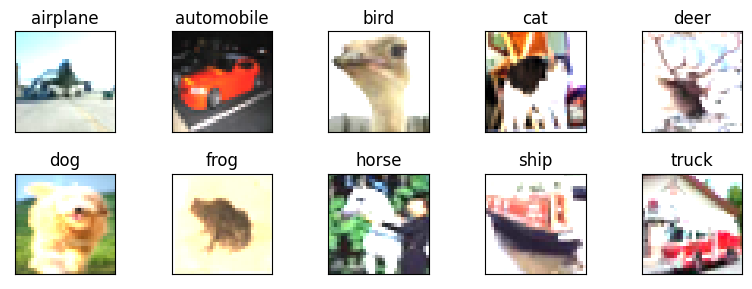

In [54]:

from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential,Model
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Input
from keras.utils import plot_model, np_utils
from matplotlib import pyplot as plt
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.utils import to_categorical, plot_model
########################################################################



num_classes = len(np.unique(y_train))
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    img = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(img)
    
plt.tight_layout()


# Trying out GAN for CIFAR-10 
> ## How do Gans Work?

>GANs try to replicate a probability distribution. They should therefore use loss functions that reflect the distance between the distribution of the data generated by the GAN and the distribution of the real data.

## Discriminator built

In [59]:


#############################################################################
#Define generator, discriminator, gan and other helper functions
#Using Sequential method from Keras as it makes the definition of models easy.
#We will use functional way of defining the model for the conditional gan
#but sequential for descriminator and generator as they are straightforward.
#########################################################################

# define the standalone discriminator model
#Given an input image, the Discriminator outputs the likelihood of the image being real.
#Binary classification - true or false (1 or 0). So using sigmoid activation.
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape)) #16x16x128
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) #8x8x128
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Flatten()) #shape of 8192
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid')) #shape of 1
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

test_discr = define_discriminator()
print(test_discr.summary())


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_108 (Conv2D)         (None, 16, 16, 128)       3584      
                                                                 
 leaky_re_lu_108 (LeakyReLU)  (None, 16, 16, 128)      0         
                                                                 
 conv2d_109 (Conv2D)         (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_109 (LeakyReLU)  (None, 8, 8, 128)        0         
                                                                 
 flatten_20 (Flatten)        (None, 8192)              0         
                                                                 
 dropout_108 (Dropout)       (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 1)               

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


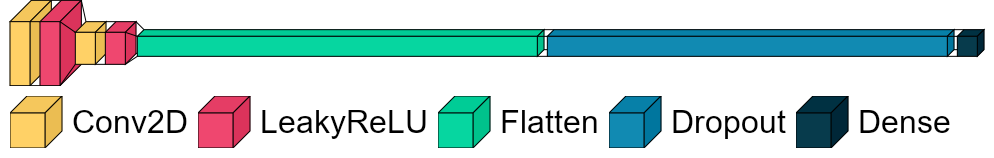

In [60]:

font = ImageFont.truetype("arial.ttf", 32)  # using comic sans is strictly prohibited!
visualkeras.layered_view(define_discriminator(), legend=True, font=font)  # font is optional!


## Generator built

In [61]:

# define the standalone generator model
# #Given input of latent vector, the Generator produces an image.(here: 32x32)
#latent_dim, for example, can be 100, 1D array of size 100 

#Here we are only using Dense and conv2dlayers. But network can be complicated based
#on the application. For example, you can use VGG for super res. GAN.       

def define_generator(latent_dim):    #latent_dim is the dimension of the latent vector (e.g., 100)
	model = Sequential()
	# We will reshape input latent vector into 8x8 image as a starting point. 
    #So n_nodes for the Dense layer can be 128x8x8 so when we reshape the output 
    #it would be 8x8x128 and that can be slowly upscaled to 32x32 image for output.
	n_nodes = 128 * 8 * 8  #8192 nodes
	model.add(Dense(n_nodes, input_dim=latent_dim)) #Dense layer so we can work with 1D latent vector
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((8, 8, 128)))  #8x8x128 dataset from the latent vector. 
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #16x16x128
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #32x32x128
	model.add(LeakyReLU(alpha=0.2))
	# generate
	model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) #32x32x3
	return model  #Model not compiled as it is not directly trained like the discriminator.
                    #Generator is trained via GAN combined model. 

test_gen = define_generator(100)
print(test_gen.summary())



Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 8192)              827392    
                                                                 
 leaky_re_lu_112 (LeakyReLU)  (None, 8192)             0         
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_113 (LeakyReLU)  (None, 16, 16, 128)      0         
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 32, 32, 128)      262272    
 ranspose)                                           

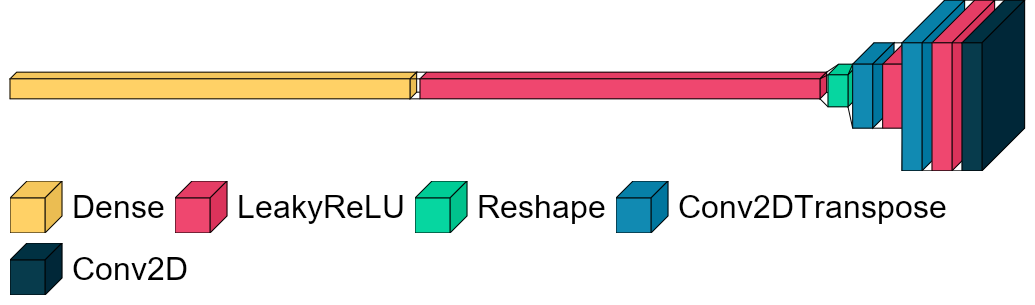

In [62]:

font = ImageFont.truetype("arial.ttf", 32)  # using comic sans is strictly prohibited!
visualkeras.layered_view(define_generator(100), legend=True, font=font)  # font is optional!


## Training the GAN

In [63]:

# define the combined generator and discriminator model, for updating the generator
#Discriminator is trained separately so here only generator will be trained by keeping
#the discriminator constant. 
def define_gan(generator, discriminator):
	discriminator.trainable = False  #Discriminator is trained separately. So set to not trainable.
	# connect generator and discriminator
	model = Sequential()
	model.add(generator)
	model.add(discriminator)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
	

# load cifar training images
def load_real_samples():
	(x_train, _), (_, _) = load_data()
	# cConvert to float and scale.
	X = x_train.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5  #Generator uses tanh activation so rescale 
                            #original images to -1 to 1 to match the output of generator.
	return X

# pick a batch of random real samples to train the GAN
#In fact, we will train the GAN on a half batch of real images and another 
#half batch of fake images. 
#For each real image we assign a label 1 and for fake we assign label 0. 
def generate_real_samples(dataset, n_samples):
	# choose random images
	ix = randint(0, dataset.shape[0], n_samples)
	# select the random images and assign it to X
	X = dataset[ix]
	# generate class labels and assign to y
	y = ones((n_samples, 1)) ##Label=1 indicating they are real
	return X, y

# generate n_samples number of latent vectors as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
#Supply the generator, latent_dim and number of samples as input.
#Use the above latent point generator to generate latent points. 
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict using generator to generate fake samples. 
	X = generator.predict(x_input)
	# Class labels will be 0 as these samples are fake. 
	y = zeros((n_samples, 1))  #Label=0 indicating they are fake
	return X, y

def summarize_performance(step, g_model, latent_dim, n_samples=100):
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    X = (X + 1) / 2.0
    for i in range(100):
        plt.subplot(10, 10, 1 + i)
        plt.axis('off')
        plt.imshow(X[i, :, :, 0], cmap='gray_r')

# train the generator and discriminator
#We loop through a number of epochs to train our Discriminator by first selecting
#a random batch of images from our true/real dataset.
#Then, generating a set of images using the generator. 
#Feed both set of images into the Discriminator. 
#Finally, set the loss parameters for both the real and fake images, as well as the combined loss. 

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)  #the discriminator model is updated for a half batch of real samples 
                            #and a half batch of fake samples, combined a single batch. 
	# manually enumerate epochs and bacthes. 
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
            
            # Train the discriminator on real and fake images, separately (half batch each)
        #Research showed that separate training is more effective. 
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
   
			# update discriminator model weights
            ##train_on_batch allows you to update weights based on a collection 
            #of samples you provide
            #Let us just capture loss and ignore accuracy value (2nd output below)
			d_loss_real, _ = d_model.train_on_batch(X_real, y_real) 
			
            # generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)
            
            #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #Average loss if you want to report single..
            
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
             
            # The generator wants the discriminator to label the generated samples
			# as valid (ones)
			#This is where the generator is trying to trick discriminator into believing
			#the generated image is true (hence value of 1 for y)			
			y_gan = ones((n_batch, 1))
            
            # Generator is part of combined model where it got directly linked with the discriminator
        # Train the generator with latent_dim as x and 1 as y. 
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of folling the discriminator then the output would be 1 (true)
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			
            # Print losses on this batch
			print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
		#print images for every 10th epoch
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

	# save the generator model
	g_model.save('./model/cifar_gan_test.h5')


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


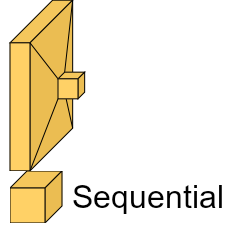

In [64]:
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
plot_model(gan_model, show_shapes=True)
font = ImageFont.truetype("arial.ttf", 32)  # using comic sans is strictly prohibited!
visualkeras.layered_view(gan_model, legend=True, font=font)  # font is optional!


In [65]:

###################################################################
#Train the GAN

# size of the latent space

# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=100)

################################################################################

# Now, let us load the generator model and generate images

from keras.models import load_model
from numpy.random import randn


# Plot generated images 
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()




2/2 [==============================] - 1s 7ms/step
Epoch>1, Batch 1/390, d1=0.691, d2=0.694 g=0.692
2/2 [==============================] - 0s 7ms/step
Epoch>1, Batch 2/390, d1=0.655, d2=0.700 g=0.687
2/2 [==============================] - 0s 6ms/step
Epoch>1, Batch 3/390, d1=0.584, d2=0.709 g=0.678
2/2 [==============================] - 0s 7ms/step
Epoch>1, Batch 4/390, d1=0.544, d2=0.723 g=0.666
2/2 [==============================] - 0s 8ms/step
Epoch>1, Batch 5/390, d1=0.489, d2=0.744 g=0.649
2/2 [==============================] - 0s 5ms/step
Epoch>1, Batch 6/390, d1=0.461, d2=0.768 g=0.639
2/2 [==============================] - 0s 5ms/step
Epoch>1, Batch 7/390, d1=0.400, d2=0.784 g=0.644
2/2 [==============================] - 0s 5ms/step
Epoch>1, Batch 8/390, d1=0.347, d2=0.764 g=0.676
2/2 [==============================] - 0s 6ms/step
Epoch>1, Batch 9/390, d1=0.320, d2=0.710 g=0.739
2/2 [==============================] - 0s 4ms/step
Epoch>1, Batch 10/390, d1=0.270, d2=0.645 g=0.815

KeyboardInterrupt: 

In [ ]:

# load model
model = load_model('./model/cifar_gan_test.h5') #Model trained for 100 epochs
# generate images
latent_points = generate_latent_points(100, 25)  #Latent dim and n_samples
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

# convert to unsigned integers for viewing
X = (X*255).astype(np.uint8)


1/1 [==============================] - 5s 5s/step


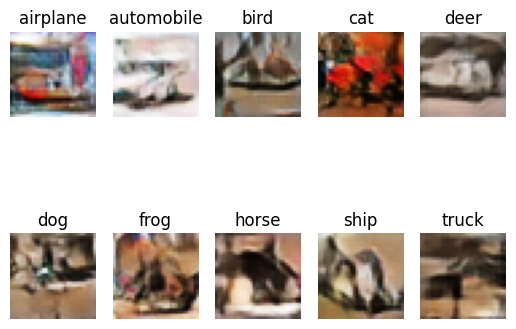

In [ ]:
# plot the result according to classes
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
for i in range(10):
    plt.subplot(2, 5, 1 + i)
    plt.axis('off')
    plt.imshow(X[i])
    plt.title(classes[i])


In [ ]:
def generator_model():
  model = tf.keras.Sequential([
      tf.keras.layers.Dense(128, input_shape=(100,), activation='relu'),
      tf.keras.layers.Reshape((8, 8, 2)),
      tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu'),
      tf.keras.layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', activation='relu'),
      tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', activation='tanh')
  ])
  return model

# Define the discriminator model
def discriminator_model():
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(32, 32, 3)),
      tf.keras.layers.LeakyReLU(0.01),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
      tf.keras.layers.LeakyReLU(0.01),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(1, activation='sigmoid')  
  ])
  return model

# Define the GAN model
def gan_model(discriminator, generator):
  model = tf.keras.Sequential()
  model.add(generator)
  model.add(discriminator)
  return model

# Compile the discriminator
discriminator = discriminator_model()
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Compile the generator
generator = generator_model()
generator.compile(optimizer='adam', loss='binary_crossentropy')

# Tuning
* Change Latent Space. Update the example to use a larger or smaller latent space and compare the quality of the results and speed of training.
* Batch Normalization. Update the discriminator and/or the generator to make use of batch normalization, recommended for DCGAN models.
* Label Smoothing. Update the example to use one-sided label smoothing when training the discriminator, specifically change the target label of real examples from 1.0 to 0.9 and add random noise, then review the effects on image quality and speed of training.
* Model Configuration. Update the model configuration to use deeper or more shallow discriminator and/or generator models, perhaps experiment with the UpSampling2D layers in the generator.
* Experience Replay 

# Measure Performance
How do you capture the difference between two distributions in GAN loss functions? This question is an area of active research, and many approaches have been proposed. We'll address two common GAN loss functions here, both of which are implemented in TF-GAN:

* minimax loss: The loss function used in the paper that introduced GANs.
* Wasserstein loss: The default loss function for TF-GAN Estimators. First described in a 2017 paper.
* FID scores
  
TF-GAN implements many other loss functions as well.

# Trying out CGAN
>In cGANs, a conditional setting is applied, meaning that both the generator and discriminator are conditioned on some sort of auxiliary information (such as class labels or data) from other modalities. As a result, the ideal model can learn multi-modal mapping from inputs to outputs by being fed with different contextual information.

* By providing additional information, we get two benefits:

* Convergence will be faster. Even the random distribution that the fake images follow will have some pattern.
* You can control the output of the generator at test time by giving the label for the image you want to generate.

# Trying out DCGAN
>DCGAN is a Deep Convolutional Generative Adversarial network that uses Deep Conv Nets to have a stable architecture and better results. The Generator in GAN uses a fully connected network, whereas DCGAN uses a Transposed Convolutional network to upsample the images.

In [84]:
# latent space dimension
latent_dim = 100
from keras import initializers
init = initializers.RandomNormal(stddev=0.02)
def dcgan_generator():
# Generator network
    generator = Sequential()

    # FC: 2x2x512
    generator.add(Dense(2*2*512, input_shape=(latent_dim,), kernel_initializer=init))
    generator.add(Reshape((2, 2, 512)))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))

    # # Conv 1: 4x4x256
    generator.add(Conv2DTranspose(256, kernel_size=5, strides=2, padding='same'))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))

    # Conv 2: 8x8x128
    generator.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding='same'))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))

    # Conv 3: 16x16x64
    generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding='same'))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))

    # Conv 4: 32x32x3
    generator.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding='same',
                                activation='tanh'))
    generator.summary()
    return generator


In [85]:
# imagem shape 32x32x3
img_shape = x_train[0].shape

# Discriminator network
def dcgan_discriminator():
    discriminator = Sequential()

    # Conv 1: 16x16x64
    discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding='same',
                            input_shape=(img_shape), kernel_initializer=init))
    discriminator.add(LeakyReLU(0.2))

    # Conv 2:
    discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))

    # Conv 3: 
    discriminator.add(Conv2D(256, kernel_size=5, strides=2, padding='same'))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))

    # Conv 3: 
    discriminator.add(Conv2D(512, kernel_size=5, strides=2, padding='same'))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))

    # FC
    discriminator.add(Flatten())

    # Output
    discriminator.add(Dense(1, activation='sigmoid'))
    # Optimizer

    discriminator.compile(Adam(lr=0.0003, beta_1=0.5), loss='binary_crossentropy',
                        metrics=['binary_accuracy'])
    print(discriminator.summary())
    return discriminator

In [86]:
def show_imgs(epoch):
        r, c = 4,4
        noise = np.random.normal(0, 1, (r * c,latent_dim))
        gen_imgs = generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,])
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
        plt.close()
def show_losses(losses):
    losses = np.array(losses)
    
    fig, ax = plt.subplots()
    plt.plot(losses.T[0], label='Discriminator')
    plt.plot(losses.T[1], label='Generator')
    plt.title("Training Losses")
    plt.legend()
    plt.show()


In [87]:
# d_g = discriminador(generador(z))
discriminator.trainable = False

z = Input(shape=(latent_dim,))
img = generator(z)
decision = discriminator(img)
d_g = Model(inputs=z, outputs=decision)

d_g.compile(Adam(lr=0.0004, beta_1=0.5), loss='binary_crossentropy',
            metrics=['binary_accuracy'])

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [88]:
# prints a summary representation of your model
d_g.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 100)]             0         
                                                                 
 model_5 (Functional)        (None, 32, 32, 3)         1051267   
                                                                 
 model_4 (Functional)        (None, 1)                 396609    
                                                                 
Total params: 1,447,876
Trainable params: 1,050,883
Non-trainable params: 396,993
_________________________________________________________________


In [89]:
epochs = 100
batch_size = 32
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
g_loss = []

for e in range(epochs + 1):
    for i in range(len(x_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = x_train[i*batch_size:(i+1)*batch_size]
        d_loss_real = discriminator.train_on_batch(x=X_batch,
                                                   y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        X_fake = generator.predict_on_batch(z)
        d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        g_loss_batch = d_g.train_on_batch(x=z, y=real)

        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(x_train) // batch_size, d_loss_batch, g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    g_loss.append(g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))

        for k in range(samples):
            plt.subplot(2, 5, k + 1, xticks=[], yticks=[])
            plt.imshow(((x_fake[k] + 1)* 127).astype(np.uint8))

        plt.tight_layout()
        plt.show()

KeyboardInterrupt: 

In [ ]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()

# Trying out ACGAN
Auxiliary Classifier Generative Adversarial Network

## Generator Built

## Discriminator Built

## Combining Generator and Discriminator

# Trying out with upsampling and BatchNorm


In [ ]:
def build_generator():

        model = Sequential()

        model.add(Dense(128 * 8 * 8, activation="relu", input_dim=latent_dim))
        model.add(Reshape((8, 8, 128)))
        
        model.add(UpSampling2D())#upsamples to 16*16*128
        
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        
        model.add(UpSampling2D()) #upsamples to 32*32*128
        
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        
        model.add(Conv2D(3, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        #outputs an image of 32*32*3

        noise = Input(shape=(latent_dim,))
        img = model(noise)
        model.summary()
        return Model(noise, img)

In [ ]:
def build_discriminator():
        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        #no normalization for the first layer 
        
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        

        img = Input(shape=img_shape)
        validity = model(img)
        model.summary()
        return Model(img, validity)

In [ ]:
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
            optimizer=Adam(0.0002,0.5),
            metrics=['accuracy'])

# Build the generator
generator = build_generator()

# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002,0.5))

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_117 (Conv2D)         (None, 16, 16, 32)        896       
                                                                 
 leaky_re_lu_123 (LeakyReLU)  (None, 16, 16, 32)       0         
                                                                 
 dropout_111 (Dropout)       (None, 16, 16, 32)        0         
                                                                 
 conv2d_118 (Conv2D)         (None, 8, 8, 64)          18496     
                                                                 
 zero_padding2d (ZeroPadding  (None, 9, 9, 64)         0         
 2D)                                                             
                                                                 
 batch_normalization_94 (Bat  (None, 9, 9, 64)         256       
 chNormalization)                                    

>mode collapsed occured

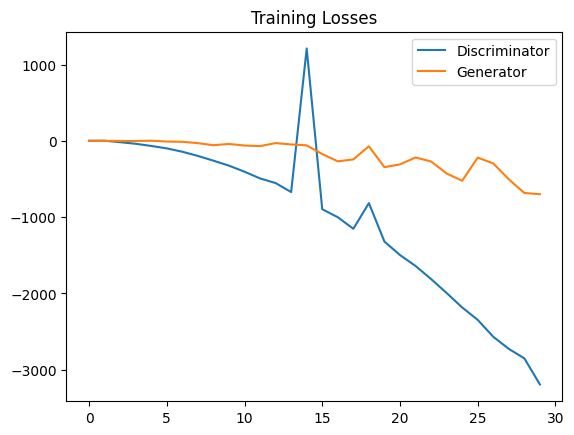

In [ ]:
show_losses(losses)

# Trying out with SAGAN

# Trying out with WGAN